In [1]:
'''
!pip install tensorflow
'''

'\n!pip install tensorflow\n'

In [2]:
import tensorflow as tf
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()
print(sess.run(hello))

b'Hello, TensorFlow!'


In [3]:
% matplotlib inline
import os
import json
import random
import re
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn
from collections import Counter
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
cred_fp = '/ebs_volume/data/Credible/'
ncred_fp = '/ebs_volume/data/notCredible/'

articles = pd.DataFrame(columns=('label',
                                 'text',
                                 'title',
                                 'date',
                                 'source'))
i = 0    
for root, dirs, files in os.walk(cred_fp):
    for file in files:
        if file.endswith(".txt") and 'api' not in file:
             curr_file = os.path.join(root, file)
             #print curr_file
             with open(curr_file) as json_file:
                try:
                    data = json.load(json_file)
                    articles.loc[i] = [0,data["text"],data["title"],data["date"],data["source"]]
                    i+=1
                except ValueError:
                    continue

for root, dirs, files in os.walk(ncred_fp):
    for file in files:
        if file.endswith(".txt") and 'api' not in file:
             curr_file = os.path.join(root, file)
             #print curr_file
             with open(curr_file) as json_file:
                try:
                    data = json.load(json_file)
                    articles.loc[i] = [1,data["text"],data["title"],data["date"],data["source"]]
                    i+=1
                except ValueError:
                    continue

In [5]:
#Remove duplicate articles
print(len(articles))
unique_articles = articles.drop_duplicates(subset = 'text')
print(len(unique_articles))

#Remove really short articles (<=200 chars)
print(len(unique_articles))
unique_articles = unique_articles[unique_articles["text"].str.len()>200]
print(len(unique_articles))

all_creds = unique_articles[unique_articles["label"]==0.0]
all_noncreds = unique_articles[unique_articles["label"]==1.0]

credible_sources = list(set(unique_articles["source"][unique_articles["label"]==0]))
non_credible_sources = list(set(unique_articles["source"][unique_articles["label"]==1]))

#Remove sources that don't contain enough articles for testing
credible_sources.remove('new-york-times')
credible_sources.remove('nature')
non_credible_sources.remove('empirenews')
non_credible_sources.remove('darkmoon')

#Shuffle lists and divide in 5 equal(ish) parts
random.shuffle(credible_sources)
random.shuffle(non_credible_sources)
credible_sources_array=np.array(credible_sources)
non_credible_sources_array=np.array(non_credible_sources)

credible_sources_arrays = np.split(credible_sources_array, [2, 4, 6, 8, 10])
non_credible_sources_arrays = np.split(non_credible_sources_array, [3, 5, 7, 9, 11])

credible_sources_arrays = credible_sources_arrays[:5]
non_credible_sources_arrays = non_credible_sources_arrays[:5]

6235
5182
5182
5048


In [6]:
#Remove stopwords from text
def remove_stopwords(in_string):
    sw = set(stopwords.words('english'))
    out_string = in_string
    out_words = out_string.split()
    out_words = [word for word in out_words if word not in sw]
    out_string = ' '.join(word for word in out_words)
    return(out_string)

#Remove words with length <=2 from text
def remove_shortwords(in_string):
    out_string = in_string
    out_words = out_string.split()
    out_words = [word for word in out_words if len(word) > 2]
    out_string = ' '.join(word for word in out_words)
    return(out_string)

#Remove words that shouldn't have the predictive power they are showing (regularization step)
def remove_overfit_words(in_string, wordlist, sourcelist, phraselist):
    out_string = in_string
    for phrase in phraselist:
        out_string.replace(remove_cap_punc(phrase), '')
    for source in sourcelist:
        out_string = out_string.replace(source, '')
    out_words = out_string.split()
    out_words = [word for word in out_words if word not in wordlist]
    out_string = ' '.join(word for word in out_words)
    return(out_string)

#Load in list of overfit words & phrases
with open("text_redactions.txt", "r") as infile:
    wordlist = []
    for line in infile:
        wordlist.append(line.replace('\n',''))

#Generate sources list
sourcelist = list(set(articles['source']))
sourcelist.append('rickrwells')
sourcelist.append('bbc')
sourcelist.append('national geographic')
sourcelist.append('gop the daily dose')
sourcelist.append('rick wells')
sourcelist.append('new york times')
sourcelist.append('washington post')

#Generate indicate phrase list
phraselist = ["Thank you for reading and sharing my work –  Please look for me, Rick Wells, at http://www.facebook.com/RickRWells/ , http://www.gab.ai/RickRWells , https://mewe.com/profile/rick.wells.1 , https://seen.life/21990861rick-wells/profile, https://plus.google.com/u/0/+RickwellsUs and on my website http://RickWells.US  – Please SUBSCRIBE in the right sidebar at RickWells.US – not dot com.  I’m also at Stop The Takeover, https://www.facebook.com/StopTheTakeover/ and please follow me on Twitter @RickRWells.",
             "Share With Your Friends On Facebook, Twitter, Everywhere",
             "Don't forget to follow the D.C. Clothesline on Facebook and Twitter. PLEASE help spread the word by sharing our articles on your favorite social networks.",
             "Reporting from",
             "globe staff"]


#Remove capitalization & punctuation
def remove_cap_punc(in_string):
    out_string = in_string
    translator = str.maketrans('', '', string.punctuation)
    out_string = out_string.translate(translator)
    out_words = out_string.split()
    out_words = [word.lower() for word in out_words]
    out_string = ' '.join(word for word in out_words)
    return(out_string)

#Perform stemming on words
def stem_words(in_string):
    snowball = nltk.stem.SnowballStemmer('english')
    out_string = in_string
    out_words = out_string.split()
    out_words = [snowball.stem(word) for word in out_words]
    out_string = ' '.join(word for word in out_words)
    return(out_string)

def dense_to_one_hot(labels_dense, num_classes):
    '''Convert class labels from scalars to one-hot vectors.'''
    num_labels = len(labels_dense)
    labels_one_hot = np.zeros((num_labels, num_classes))
    label_list = list(set(labels_dense))
    for i, label in enumerate(labels_dense):
        labels_one_hot[i][label_list.index(label)] = 1
    return labels_one_hot


In [7]:
scores_nb = []
f_scores_nb = []
confusion_nb = np.array([[0, 0], [0, 0]])

i=0

for cred_array in credible_sources_arrays:
    #1) Generate Train/Test splits by source
    cred_list = list(cred_array)    
    holdout_creds = all_creds[all_creds["source"].isin(cred_list)]
    train_creds = all_creds[~all_creds["source"].isin(cred_list)]
    
    for non_cred_array in non_credible_sources_arrays:
        non_cred_list = list(non_cred_array)
        holdout_noncreds = all_noncreds[all_noncreds["source"].isin(non_cred_list)].sample(n=len(holdout_creds))
        train_noncreds = all_noncreds[~all_noncreds["source"].isin(non_cred_list)].sample(n=len(train_creds))
        
        train_articles = pd.concat([train_creds, train_noncreds])
        test_articles = pd.concat([holdout_creds, holdout_noncreds])
        
        #2) Text preprocessing
        train_articles['filtered_text'] = train_articles['text'].apply(remove_cap_punc)
        test_articles['filtered_text'] = test_articles['text'].apply(remove_cap_punc)
        
        train_articles['filtered_text'] = train_articles.apply(lambda x: remove_overfit_words(x['filtered_text'], wordlist=wordlist, sourcelist=sourcelist, phraselist=phraselist), axis=1)
        test_articles['filtered_text'] = test_articles.apply(lambda x: remove_overfit_words(x['filtered_text'], wordlist=wordlist, sourcelist=sourcelist, phraselist=phraselist), axis=1)
        
        train_articles['filtered_text'] = train_articles['filtered_text'].apply(remove_shortwords)
        test_articles['filtered_text'] = test_articles['filtered_text'].apply(remove_shortwords)
        
        train_articles['filtered_text'] = train_articles['filtered_text'].apply(remove_stopwords)
        train_articles['filtered_text'] = train_articles['filtered_text'].apply(remove_shortwords)
        test_articles['filtered_text'] = test_articles['filtered_text'].apply(remove_stopwords)
        test_articles['filtered_text'] = test_articles['filtered_text'].apply(remove_shortwords)
        
        #3) MNB classification
        count_vect = CountVectorizer(analyzer='word', ngram_range=(1,1), min_df=0.05)
        tfidf = TfidfTransformer()
    
        confusion = np.array([[0, 0], [0, 0]])
        train_text = train_articles['filtered_text'].values
        train_counts = count_vect.fit_transform(train_text)
        train_tfidf = tfidf.fit_transform(train_counts)
        train_y = train_articles['label'].values

        test_text = test_articles['filtered_text'].values
        test_counts = count_vect.transform(test_text)
        test_tfidf = tfidf.transform(test_counts)
        test_y = test_articles['label'].values

        clf = MultinomialNB().fit(train_tfidf, train_y)
        predictions = clf.predict(test_tfidf)

        confusion_nb += confusion_matrix(test_y, predictions)
        f_score_nb = f1_score(test_y, predictions)
        score_nb = accuracy_score(test_y, predictions)
        scores_nb.append(score_nb)
        f_scores_nb.append(f_score_nb)
        
        print("[MNB] -- Test on {0} & {1}".format(cred_list, non_cred_list))
        print('Total articles classified:', len(predictions))
        print('Accuracy Score:', round(score_nb, 3))
        print('F1 Score:', round(f_score_nb, 3))
        print('Confusion matrix:')
        print(confusion_matrix(test_y, predictions))
        print()
        
        i+=1
        print("COMPLETED {0}/{1} ITERATIONS".format(i,len(credible_sources_arrays)*len(non_credible_sources_arrays)))
        print()
        
print('GENERALIZATION (MNB) Metrics')
print('Accuracy Score:', round(sum(scores_nb)/len(scores_nb),3))
print('F1 Score:', round(sum(f_scores_nb)/len(f_scores_nb),3))
print('Confusion matrix:')
print(confusion_nb)
print()

[MNB] -- Test on ['usa-today', 'reuters'] & ['usfanzone', 'gopthedailydose', 'infostormer']
Total articles classified: 778
Accuracy Score: 0.868
F1 Score: 0.868
Confusion matrix:
[[335  54]
 [ 49 340]]

COMPLETED 1/25 ITERATIONS

[MNB] -- Test on ['usa-today', 'reuters'] & ['dcclothesline', 'ItMakesSenseBlog']
Total articles classified: 778
Accuracy Score: 0.794
F1 Score: 0.777
Confusion matrix:
[[340  49]
 [111 278]]

COMPLETED 2/25 ITERATIONS

[MNB] -- Test on ['usa-today', 'reuters'] & ['activistpost', 'success-street']
Total articles classified: 778
Accuracy Score: 0.752
F1 Score: 0.719
Confusion matrix:
[[338  51]
 [142 247]]

COMPLETED 3/25 ITERATIONS

[MNB] -- Test on ['usa-today', 'reuters'] & ['rickwells', 'usanewsflash']
Total articles classified: 778
Accuracy Score: 0.896
F1 Score: 0.901
Confusion matrix:
[[330  59]
 [ 22 367]]

COMPLETED 4/25 ITERATIONS

[MNB] -- Test on ['usa-today', 'reuters'] & ['usapoliticsnow', 'usasupreme']
Total articles classified: 778
Accuracy Scor

994
2


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


0
step 0, training accuracy 0.48853
step 0, cost 1034.88
step 0, change in cost 1034.88
10
step 10, training accuracy 0.487097
step 10, cost 1000.15
step 10, change in cost 34.7305
20
step 20, training accuracy 0.487097
step 20, cost 974.585
step 20, change in cost 25.5673
30
step 30, training accuracy 0.489964
step 30, cost 957.38
step 30, change in cost 17.2052
40
step 40, training accuracy 0.491756
step 40, cost 945.385
step 40, change in cost 11.995
50
step 50, training accuracy 0.498566
step 50, cost 936.056
step 50, change in cost 9.32959
60
step 60, training accuracy 0.501792
step 60, cost 927.966
step 60, change in cost 8.08936
70
step 70, training accuracy 0.506452
step 70, cost 920.439
step 70, change in cost 7.52759
80
step 80, training accuracy 0.510753
step 80, cost 913.168
step 80, change in cost 7.27087
90
step 90, training accuracy 0.51828
step 90, cost 906.026
step 90, change in cost 7.14197
100
step 100, training accuracy 0.525448
step 100, cost 898.957
step 100, chan

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0
step 0, training accuracy 0.527387
step 0, cost 850.719
step 0, change in cost 850.719
10
step 10, training accuracy 0.534429
step 10, cost 826.502
step 10, change in cost 24.2169
20
step 20, training accuracy 0.540297
step 20, cost 810.471
step 20, change in cost 16.0312
30
step 30, training accuracy 0.544992
step 30, cost 799.245
step 30, change in cost 11.2256
40
step 40, training accuracy 0.548122
step 40, cost 790.553
step 40, change in cost 8.69232
50
step 50, training accuracy 0.553208
step 50, cost 783.127
step 50, change in cost 7.42627
60
step 60, training accuracy 0.559859
step 60, cost 776.329
step 60, change in cost 6.79767
70
step 70, training accuracy 0.564554
step 70, cost 769.853
step 70, change in cost 6.47571
80
step 80, training accuracy 0.568858
step 80, cost 763.561
step 80, change in cost 6.29285
90
step 90, training accuracy 0.57277
step 90, cost 757.388
step 90, change in cost 6.17303
100
step 100, training accuracy 0.578638
step 100, cost 751.307
step 100, c

TypeError: 'numpy.float32' object is not iterable

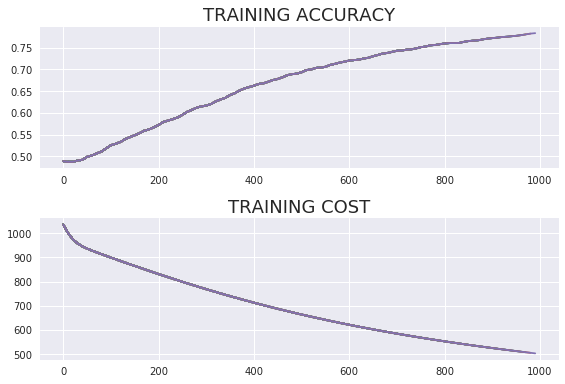

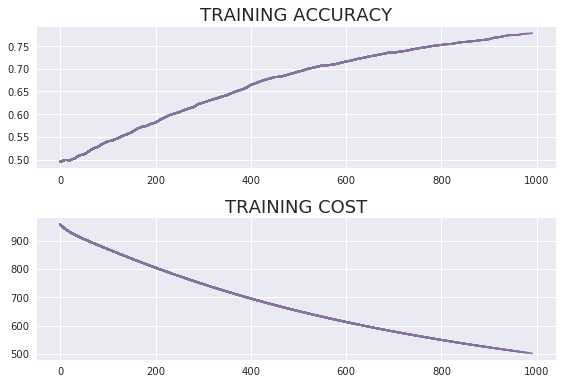

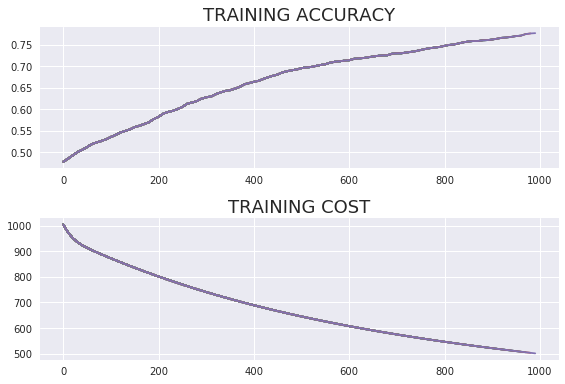

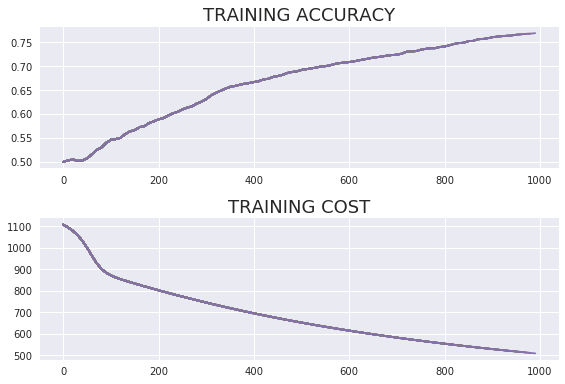

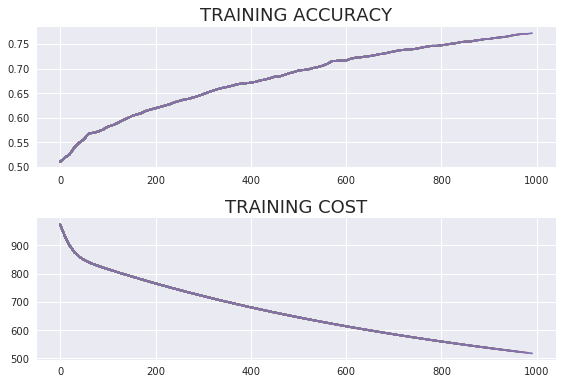

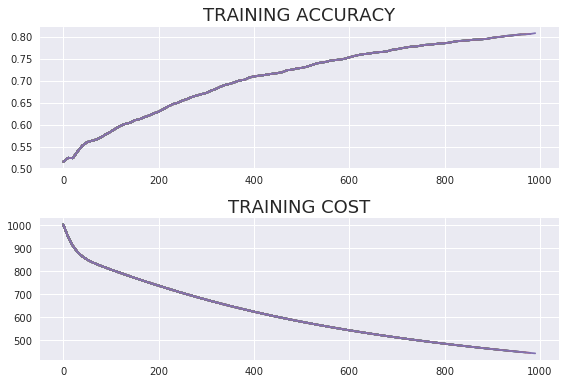

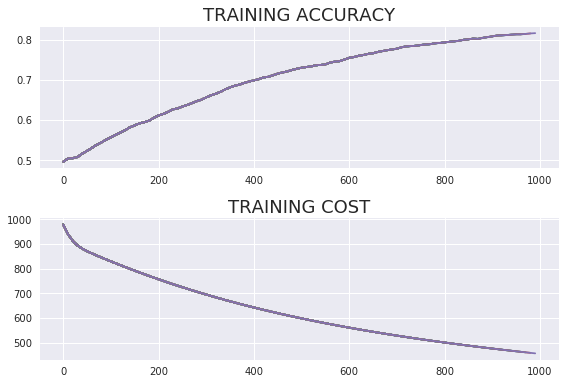

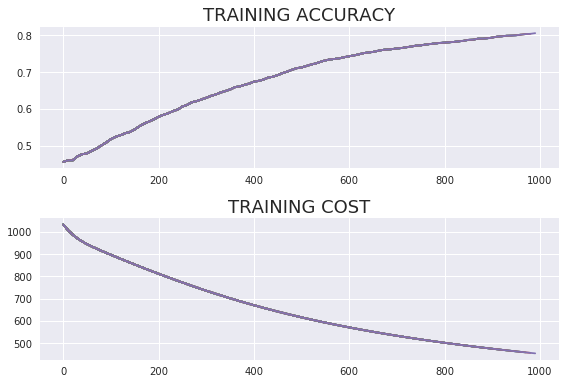

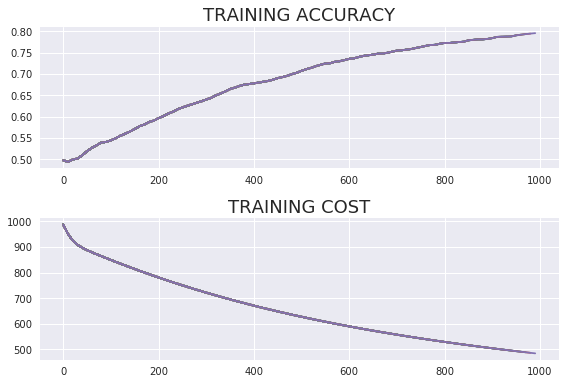

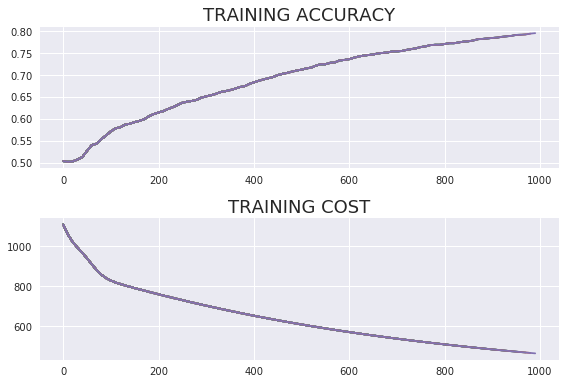

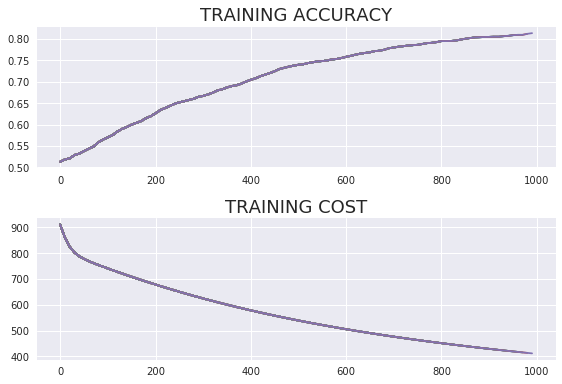

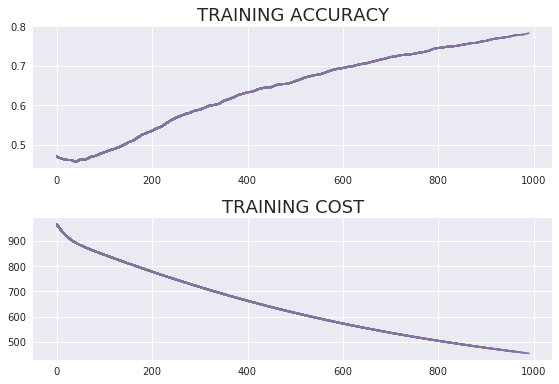

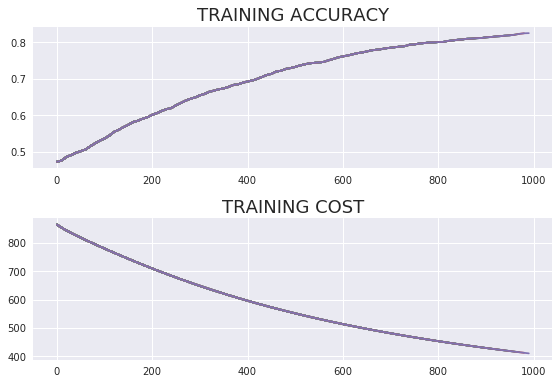

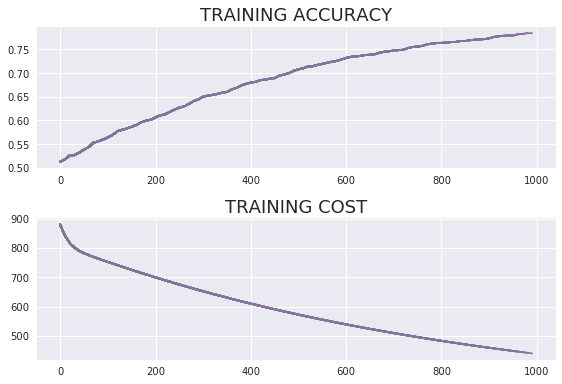

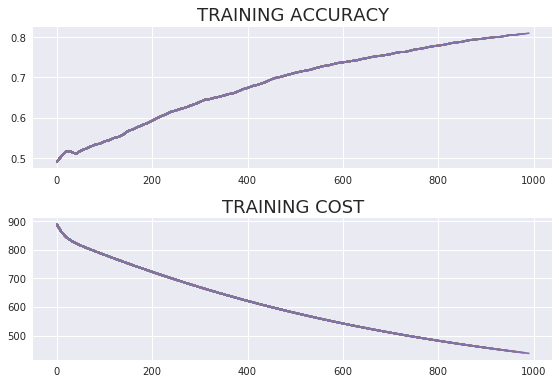

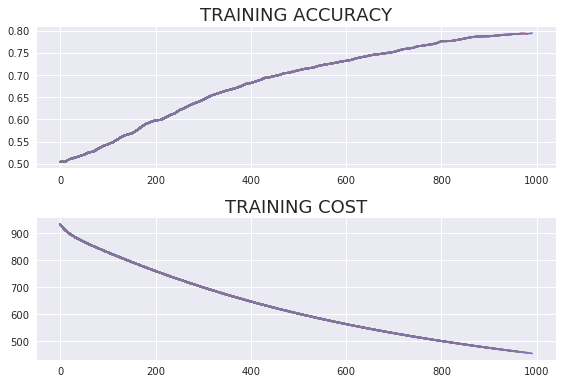

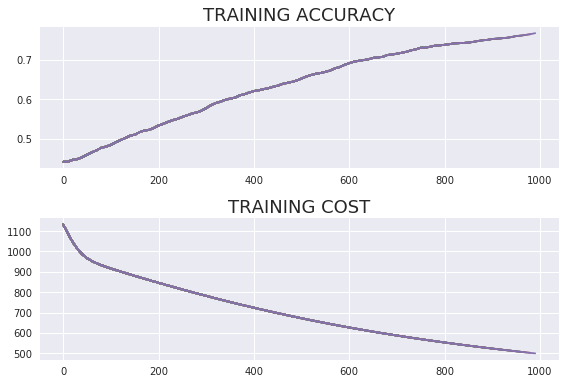

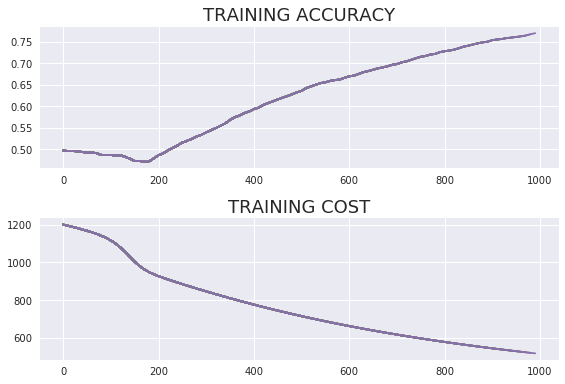

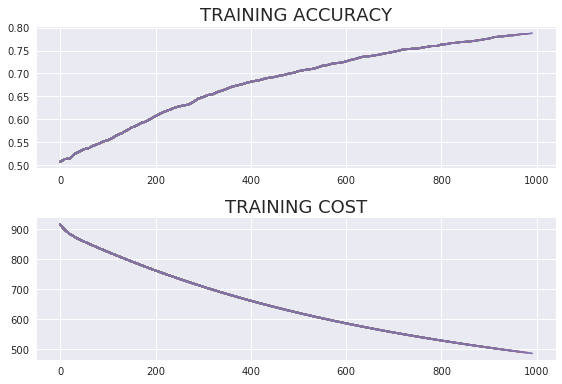

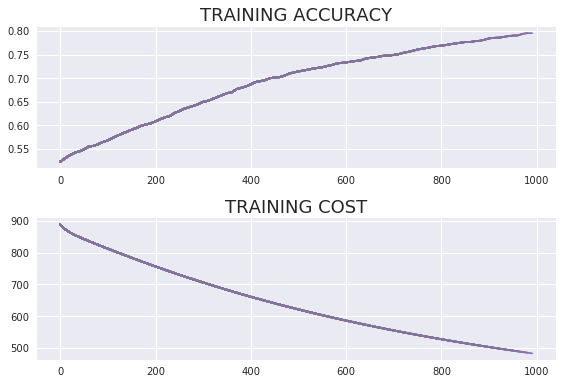

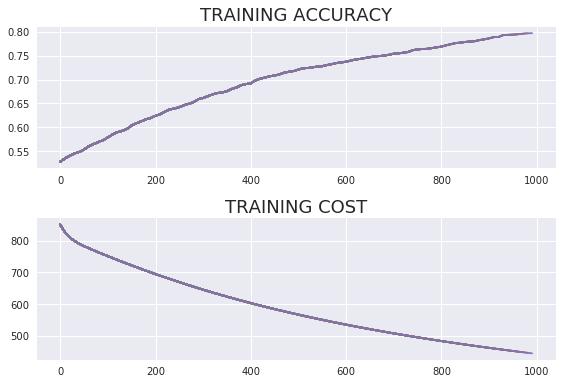

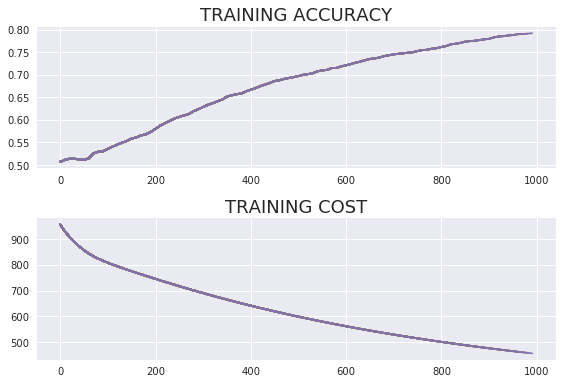

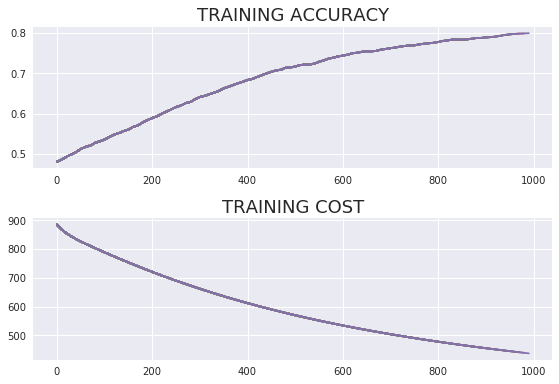

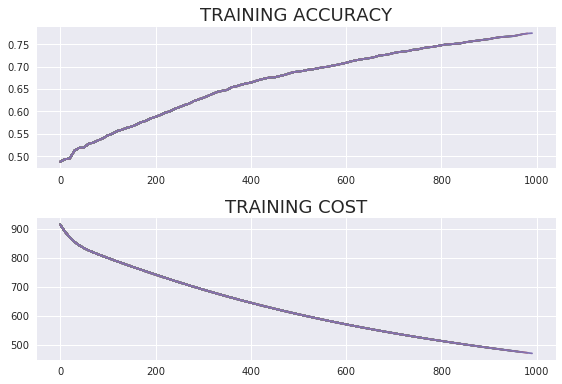

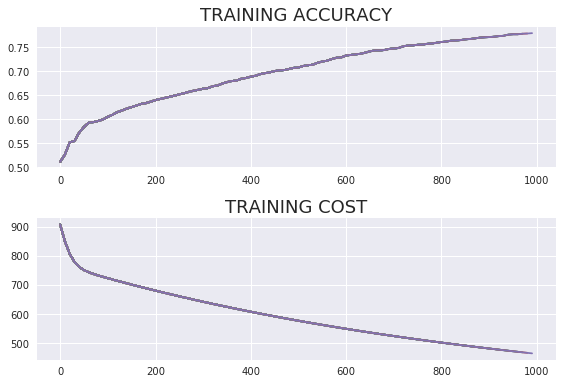

In [ ]:
scores_tf = []
f_scores_tf = []
confusion_tf = np.array([[0, 0], [0, 0]])

j=0
import time

for cred_array in credible_sources_arrays:
    #1) Generate Train/Test splits by source
    cred_list = list(cred_array)    
    holdout_creds = all_creds[all_creds["source"].isin(cred_list)]
    train_creds = all_creds[~all_creds["source"].isin(cred_list)]
    
    for non_cred_array in non_credible_sources_arrays:
        non_cred_list = list(non_cred_array)
        holdout_noncreds = all_noncreds[all_noncreds["source"].isin(non_cred_list)].sample(n=len(holdout_creds))
        train_noncreds = all_noncreds[~all_noncreds["source"].isin(non_cred_list)].sample(n=len(train_creds))
        
        train_articles = pd.concat([train_creds, train_noncreds])
        test_articles = pd.concat([holdout_creds, holdout_noncreds])
        
        #2) Text preprocessing
        train_articles['filtered_text'] = train_articles['text'].apply(remove_cap_punc)
        test_articles['filtered_text'] = test_articles['text'].apply(remove_cap_punc)
        
        train_articles['filtered_text'] = train_articles.apply(lambda x: remove_overfit_words(x['filtered_text'], wordlist=wordlist, sourcelist=sourcelist, phraselist=phraselist), axis=1)
        test_articles['filtered_text'] = test_articles.apply(lambda x: remove_overfit_words(x['filtered_text'], wordlist=wordlist, sourcelist=sourcelist, phraselist=phraselist), axis=1)
        
        train_articles['filtered_text'] = train_articles['filtered_text'].apply(remove_shortwords)
        test_articles['filtered_text'] = test_articles['filtered_text'].apply(remove_shortwords)
        
        train_articles['filtered_text'] = train_articles['filtered_text'].apply(remove_stopwords)
        train_articles['filtered_text'] = train_articles['filtered_text'].apply(remove_shortwords)
        test_articles['filtered_text'] = test_articles['filtered_text'].apply(remove_stopwords)
        test_articles['filtered_text'] = test_articles['filtered_text'].apply(remove_shortwords)
        
        #3) tensor flow
        count_vect = CountVectorizer(analyzer='word', ngram_range=(1,1), min_df=0.05)
        tfidf = TfidfTransformer()
    
        confusion = np.array([[0, 0], [0, 0]])
        train_text = train_articles['filtered_text'].values
        train_counts = count_vect.fit_transform(train_text)
        train_tfidf = tfidf.fit_transform(train_counts)
        trainX = np.array(train_tfidf.toarray())
        numFeatures = trainX.shape[1]
        print(numFeatures)
        trainY = np.array(dense_to_one_hot(train_articles['label'].values,2))
        numLabels = trainY.shape[1]
        print(numLabels)

        test_text = test_articles['filtered_text'].values
        test_counts = count_vect.transform(test_text)
        test_tfidf = tfidf.transform(test_counts)
        testX = np.array(test_tfidf.toarray())
        testY = np.array(dense_to_one_hot(test_articles['label'].values,2))
        
        # TRAINING SESSION PARAMETERS
        # number of times we iterate through training data
        # tensorboard shows that accuracy plateaus at ~25k epochs
        numEpochs = 27000 #27000
        # a smarter learning rate for gradientOptimizer
        learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)
        
        X = tf.placeholder(tf.float32, [None, numFeatures])
        yGold = tf.placeholder(tf.float32, [None, numLabels])
        
        # Values are randomly sampled from a Gaussian with a standard deviation of:
        #     sqrt(6 / (numInputNodes + numOutputNodes + 1))

        weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

        bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))
        
        # INITIALIZE our weights and biases
        init_OP = tf.global_variables_initializer()

        # PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
        apply_weights_OP = tf.matmul(X, weights, name="apply_weights")
        add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
        activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")
        
        # COST FUNCTION i.e. MEAN SQUARED ERROR
        cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")
        
        # OPTIMIZATION ALGORITHM i.e. GRADIENT DESCENT
        training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)
        
        epoch_values=[]
        accuracy_values=[]
        cost_values=[]
        
        # Turn on interactive plotting
        plt.ion()
        # Create the main, super plot
        fig = plt.figure()
        # Create two subplots on their own axes and give titles
        ax1 = plt.subplot("211")
        ax1.set_title("TRAINING ACCURACY", fontsize=18)
        ax2 = plt.subplot("212")
        ax2.set_title("TRAINING COST", fontsize=18)
        plt.tight_layout()
        
        # Create a tensorflow session
        sess = tf.Session()

        # Initialize all tensorflow variables
        sess.run(init_OP)

        ## Ops for vizualization
        # argmax(activation_OP, 1) gives the label our model thought was most likely
        # argmax(yGold, 1) is the correct label
        correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
        # False is 0 and True is 1, what was our average?
        accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
        # Summary op for regression output
        activation_summary_OP = tf.summary.histogram("output", activation_OP)
        # Summary op for accuracy
        accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)
        # Summary op for cost
        cost_summary_OP = tf.summary.scalar("cost", cost_OP)
        # Summary ops to check how variables (W, b) are updating after each iteration
        weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
        biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))
        # Merge all summaries
        #all_summary_OPS = tf.summary.merge_all()
        #all_summary_OPS = tf.merge_summary([weightSummary,biasSummary])
        all_summary_OPS = tf.summary.merge([weightSummary,biasSummary])
        # Summary writer
        writer = tf.summary.FileWriter("summary_logs", sess.graph)

        # Initialize reporting variables
        cost = 0
        diff = 1

        # Training epochs
        for i in range(numEpochs):
            if i > 1 and diff < .0001:
                print("change in cost %g; convergence."%diff)
                break
            else:
                # Run training step
                step = sess.run(training_OP, feed_dict={X: trainX, yGold: trainY})
                # Report occasional stats
                if i % 10000 == 0:
                    print(i)
                    # Add epoch to epoch_values
                    epoch_values.append(i)
                    # Generate accuracy stats on test data
                    summary_results, train_accuracy, newCost = sess.run(
                        [all_summary_OPS, accuracy_OP, cost_OP], 
                        feed_dict={X: trainX, yGold: trainY}
                    )
                    # Add accuracy to live graphing variable
                    accuracy_values.append(train_accuracy)
                    # Add cost to live graphing variable
                    cost_values.append(newCost)
                    # Write summary stats to writer
                    writer.add_summary(summary_results, i)
                    # Re-assign values for variables
                    diff = abs(newCost - cost)
                    cost = newCost

                    #generate print statements
                    print("step %d, training accuracy %g"%(i, train_accuracy))
                    print("step %d, cost %g"%(i, newCost))
                    print("step %d, change in cost %g"%(i, diff))

                    # Plot progress to our two subplots
                    accuracyLine, = ax1.plot(epoch_values, accuracy_values)
                    costLine, = ax2.plot(epoch_values, cost_values)
                    fig.canvas.draw()
                    time.sleep(1)


        # How well do we perform on held-out test data?
        print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={X: testX, 
                                                                yGold: testY})))
        
        scores_tf = sess.run(accuracy_OP, feed_dict={X: testX, yGold: testY})
        
        j+=1
        print("COMPLETED {0}/{1} ITERATIONS".format(j,len(credible_sources_arrays)*len(non_credible_sources_arrays)))
        print()
        
print('GENERALIZATION Metrics')
print('Accuracy Score:', round(sum(scores_tf)/len(scores_tf),3))
#print('F1 Score:', round(sum(f_scores_tf)/len(f_scores_tf),3))
#print('Confusion matrix:')
#print(confusion_tf)
print()

In [ ]:
print(scores_tf)

In [ ]:
# Create Saver
saver = tf.train.Saver()
# Save variables to .ckpt file
 saver.save(sess, "tf_default_model_rained_variables.ckpt")

# Close tensorflow session
sess.close()

In [ ]:
#Average accuracy of the above model is 0.727 (across the 25 iterations). Training time ~  2hours for entire cv

In [101]:
#print(train_tfidf.toarray())
trainX = np.array(train_tfidf.toarray())
print(trainX)
numFeatures = trainX.shape[1]
print(numFeatures)
trainY = np.array(dense_to_one_hot(train_articles['label'].values,2))
numLabels = trainY.shape[1]
print(trainY)
print(numLabels)

[[ 0.          0.          0.07383444 ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.09192385]
 [ 0.          0.0700517   0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
998
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
2


In [ ]:
np.array(dense_to_one_hot(train_articles['label'].values,2))